In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from astropy.coordinates import CartesianRepresentation, UnitSphericalRepresentation
from astropy.coordinates.matrix_utilities import rotation_matrix, matrix_product

In [2]:
from scipy.integrate import quad 

def limb_darkening(u_ld, r):
    u1, u2 = u_ld
    mu = np.sqrt(1 - r**2)
    return (1 - u1 * (1 - mu) - u2 * (1 - mu)**2) / (1 - u1/3 - u2/6) / np.pi

def limb_darkening_normed(u_ld, r): 
    return limb_darkening(u_ld, r)/limb_darkening(u_ld, 0)

def total_flux(u_ld): 
    return 2 * np.pi * quad(lambda r: r * limb_darkening_normed(u_ld, r), 0, 1)[0]

spot_contrast = 0.7
u_ld = [0.5079, 0.2239]
f0 = total_flux(u_ld)

In [3]:
n_rotations = 30
angles = np.arange(0, 2*np.pi, 2*np.pi/n_rotations) * u.rad

In [85]:
n_incs = 1000
inc_stellar = np.sort(180*np.random.rand(n_incs) - 90) * u.deg #60 * np.ones(n_incs) * u.deg

spot_radii = np.array([0.2, 0.2, 0.1])
spot_lats = np.array([0, 80, 20])*u.deg
spot_lons = np.array([0, 180, 180])*u.deg
# spot_radii = np.array([0.2])
# spot_lats = np.array([60])*u.deg
# spot_lons = np.array([180])*u.deg

def lightcurve(spot_lons, spot_lats, spot_radii, inc_stellar):
    usr = UnitSphericalRepresentation(spot_lons * np.ones((n_rotations, 1, 1)), 
                                      spot_lats * np.ones((n_rotations, 1, 1))) 
    cartesian = usr.represent_as(CartesianRepresentation)
    rotate = rotation_matrix(angles[:, np.newaxis, np.newaxis], axis='z')
    tilt = rotation_matrix(-(90*u.deg - inc_stellar[np.newaxis, :, np.newaxis]), axis='y')
    rotated_spot_positions = cartesian.transform(rotate)
    tilted_spot_positions = rotated_spot_positions.transform(tilt)

    r = np.ma.masked_array(np.sqrt(tilted_spot_positions.y**2 + tilted_spot_positions.z**2), 
                           mask=tilted_spot_positions.x < 0)
    ld = limb_darkening_normed(u_ld, r)

    f_spots = np.pi * spot_radii**2 * (1 - spot_contrast) * ld * np.sqrt(1 - r**2)

    delta_f = (1 - np.sum(f_spots/f0, axis=-1)).data
    return delta_f/delta_f.max(axis=0)

In [86]:
delta_f = lightcurve(spot_lons, spot_lats, spot_radii, inc_stellar)

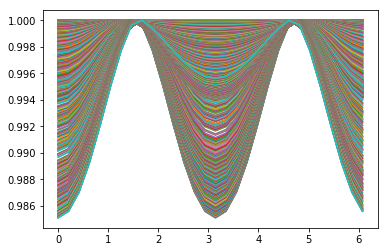

In [87]:
plt.plot(angles, delta_f);

In [81]:
# n_stars = 500
# ptp = []
# for _ in range(n_stars):
#     n_spots = 3
#     spot_lats = (20*np.random.rand(n_spots) + 70) * u.deg
#     spot_lons = 360*np.random.rand(n_spots) * u.deg
#     spot_radii = 0.23
#     inc_stellar = (180*np.random.rand() - 90) * u.deg
#     delta_f = lightcurve(spot_lons, spot_lats, spot_radii, inc_stellar)
#     ptp.append(np.ptp(delta_f/delta_f.max()))

(array([  77.,  124.,  113.,   75.,   40.,   33.,   19.,    9.,    6.,    4.]),
 array([  8.19418818e-05,   3.04183196e-03,   6.00172205e-03,
          8.96161213e-03,   1.19215022e-02,   1.48813923e-02,
          1.78412824e-02,   2.08011725e-02,   2.37610625e-02,
          2.67209526e-02,   2.96808427e-02]),
 <a list of 10 Patch objects>)

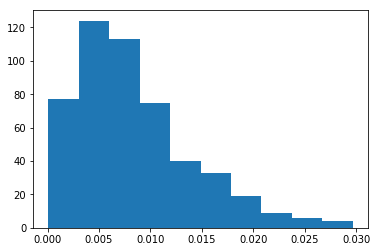

In [88]:
plt.hist(ptp)

In [83]:
from rms import Star, Planet, Spot, STSP
from astropy.time import Time

planet = Planet.non_transiting()
planet.t0 = 0

spots = []
for i in range(len(spot_lats)):
    spots.append(Spot(spot_lats[i], spot_lons[i], spot_radii[i]))
    
star = Star(planet=planet, rotation_period=2*np.pi, inc_stellar=inc_stellar[0].to(u.degree).value, u=u_ld)

with STSP(Time(angles.value, format='jd'), star, spots) as s: 
    lc = s.generate_lightcurve()

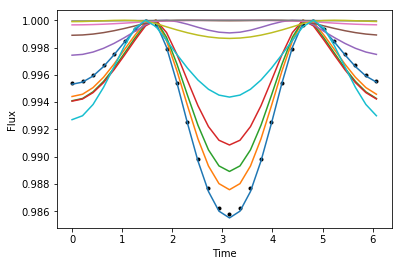

In [84]:
lc.plot(show=False)
plt.plot(angles, delta_f/delta_f.max())